DATA CREATION

You're simulating a pricing experiment for a freemium productivity app.
The company wants to test how different price points affect conversion rate and revenue.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(25)

n = 3000

# Simulate 3 price points: $5, $10, $15
prices = np.random.choice([5, 10, 15], size=n, p=[0.3, 0.4, 0.3])

# Simulate conversion probabilities
def simulate_conversion(p):
    if p == 5:
        return np.random.binomial(1, 0.18)
    elif p == 10:
        return np.random.binomial(1, 0.12)
    else:
        return np.random.binomial(1, 0.06)

df = pd.DataFrame({
    'User_ID': np.arange(1, n + 1),
    'Price_Offered': prices
})

df['Converted'] = df['Price_Offered'].apply(simulate_conversion)
df['Revenue'] = df['Converted'] * df['Price_Offered']

df.to_csv("pricing_experiment.csv", index=False)


## Task:
1. Conversion & Revenue Breakdown:
    - What is the conversion rate at each price point?
    - What is the total revenue generated from each?
    - Create a visual trade-off chart (price vs. conversion vs. revenue).

2. Find the Sweet Spot:
    - Which price gives the best revenue?
    - Which price gives best conversion?
    - What would you recommend to maximize total revenue while maintaining user base?

3. Run a What-If Scenario:
    - Imagine a fourth price point: $7
        - Estimate its conversion using linear interpolation between $5 and $10.
        - Add it to your analysis: how would it change the revenue curve?

In [2]:
df.head()

,User_ID,Price_Offered,Converted,Revenue
0,1,15,0,0
1,2,10,0,0
2,3,5,0,0
3,4,5,1,5
4,5,10,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_ID        3000 non-null   int64
 1   Price_Offered  3000 non-null   int64
 2   Converted      3000 non-null   int64
 3   Revenue        3000 non-null   int64
dtypes: int64(4)
memory usage: 93.9 KB


In [4]:
df['Converted'].value_counts()

Converted
0    2610
1     390
Name: count, dtype: int64

In [5]:
df['Price_Offered'].value_counts()

Price_Offered
10    1221
15     903
5      876
Name: count, dtype: int64

In [6]:
df_converted = df.groupby('Price_Offered')['Converted'].sum() / df.groupby('Price_Offered')['Price_Offered'].count() *100
df_converted

Price_Offered
5     18.721461
10    14.250614
15     5.758583
dtype: float64

In [7]:
df_revenue = df.groupby('Price_Offered')['Revenue'].sum()
df_revenue

Price_Offered
5      820
10    1740
15     780
Name: Revenue, dtype: int64

In [8]:
df_price = df['Price_Offered'].value_counts().sort_index()
df_price

Price_Offered
5      876
10    1221
15     903
Name: count, dtype: int64

In [9]:
df_summary = pd.DataFrame({
    'Total_users' : df_price,
    'Total_Revenue' : df_revenue,
    'Conversion_Rate' : df_converted
})

# Calculate ARPU (Average Revenue Per User)
df_summary['ARPU'] = df_summary['Total_Revenue'] / df_summary['Total_users']
df_summary.reset_index(inplace=True)  # So that Price_Offered becomes a column

In [10]:
df_summary

,Price_Offered,Total_users,Total_Revenue,Conversion_Rate,ARPU
0,5,876,820,18.721461,0.936073
1,10,1221,1740,14.250614,1.425061
2,15,903,780,5.758583,0.863787


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

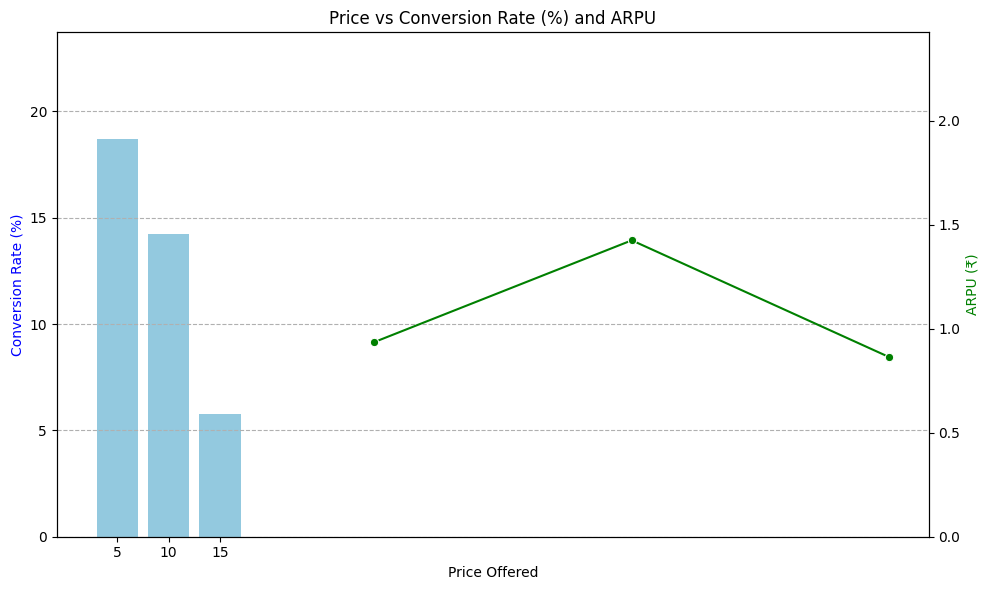

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: Conversion Rate
sns.barplot(x='Price_Offered', y='Conversion_Rate', data=df_summary, ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)', color='blue')
ax1.set_xlabel('Price Offered')
ax1.set_ylim(0, df_summary['Conversion_Rate'].max() + 5)

# Line chart: ARPU
ax2 = ax1.twinx()
sns.lineplot(x='Price_Offered', y='ARPU', data=df_summary, ax=ax2, color='green', marker='o')
ax2.set_ylabel('ARPU (₹)', color='green')
ax2.set_ylim(0, df_summary['ARPU'].max() + 1)

plt.title('Price vs Conversion Rate (%) and ARPU')
ax1.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [13]:
# Existing price point and conversion rates
existing = {
    5 : 18.7,
    10 : 14.2
}

In [14]:
# Linear Interpolation for price 7

x0, y0 = 5, existing[5]
x1, y1 = 10, existing[10]

x_new = 7
y_new = y0 + (x_new - x0) * (y1 - y0)/(x1 - x0)
conversion_7 = y_new

In [15]:
# Simulate for 1000 users at price 7

n_user_7 = df_summary['Total_users'].mean()
converted_7 = int((conversion_7*n_user_7)/100)
revenue_7 = converted_7*7
arpu_7 = revenue_7/n_user_7

df_new_7 = pd.DataFrame({
    'Price_Offered' : [7],
    'Total_users' : [n_user_7],
    'Total_Revenue' : [revenue_7],
    'Conversion_Rate' : [conversion_7],
    'ARPU' : [arpu_7]
})

df_new_7

,Price_Offered,Total_users,Total_Revenue,Conversion_Rate,ARPU
0,7,1000.0,1183,16.9,1.183


In [16]:
df_all = pd.concat([df_summary, df_new_7], ignore_index = True).sort_values('Price_Offered')
df_all

,Price_Offered,Total_users,Total_Revenue,Conversion_Rate,ARPU
0,5,876.0,820,18.721461,0.936073
3,7,1000.0,1183,16.900000,1.183000
1,10,1221.0,1740,14.250614,1.425061
2,15,903.0,780,5.758583,0.863787


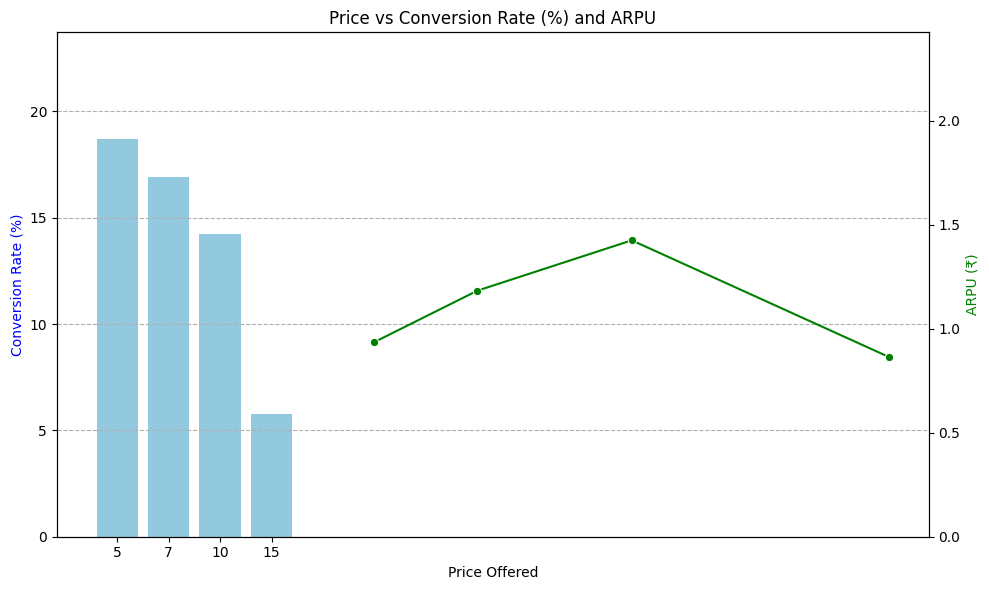

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: Conversion Rate
sns.barplot(x='Price_Offered', y='Conversion_Rate', data=df_all, ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)', color='blue')
ax1.set_xlabel('Price Offered')
ax1.set_ylim(0, df_summary['Conversion_Rate'].max() + 5)

# Line chart: ARPU
ax2 = ax1.twinx()
sns.lineplot(x='Price_Offered', y='ARPU', data=df_all, ax=ax2, color='green', marker='o')
ax2.set_ylabel('ARPU (₹)', color='green')
ax2.set_ylim(0, df_summary['ARPU'].max() + 1)

plt.title('Price vs Conversion Rate (%) and ARPU')
ax1.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


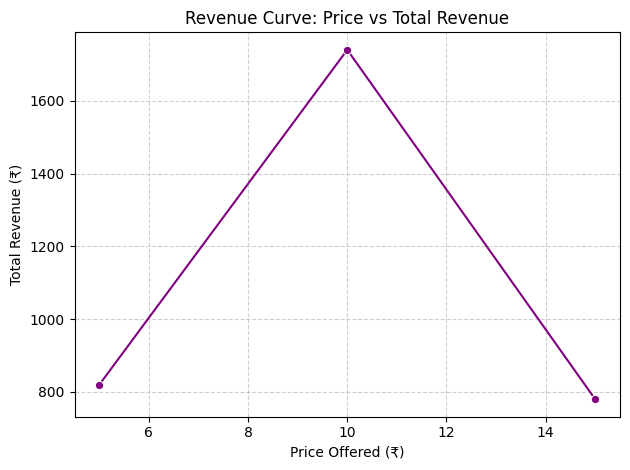

In [18]:
sns.lineplot(x='Price_Offered', y='Total_Revenue', data=df_summary, marker='o', color='purple')
plt.title('Revenue Curve: Price vs Total Revenue')
plt.xlabel('Price Offered (₹)')
plt.ylabel('Total Revenue (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


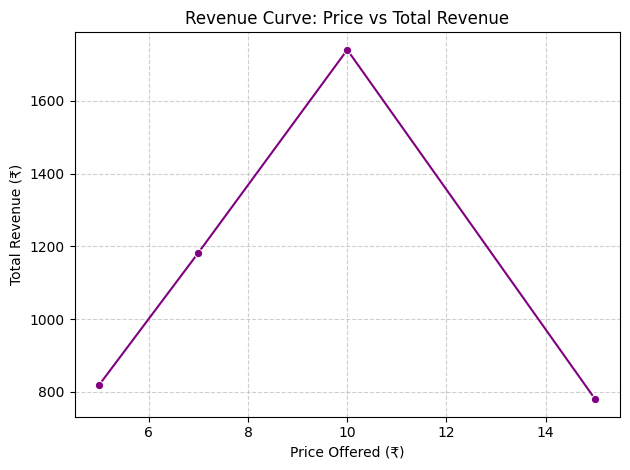

In [19]:
sns.lineplot(x='Price_Offered', y='Total_Revenue', data=df_all, marker='o', color='purple')
plt.title('Revenue Curve: Price vs Total Revenue')
plt.xlabel('Price Offered (₹)')
plt.ylabel('Total Revenue (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
